In [1]:
# pyenv activate loan-approval-env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
import torch as tt
import torchvision as ttv
import statsmodels.api as sm
import plotly.express as px
import plotly.io as pio
import nltk
import string
import re
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

In [2]:
# load data and check to see how many nulls in each category we have

data = pd.read_csv("loan_data.csv")

def null_nums(list):
    for l in list:
        print("Column: ", l)
        print(data[l].isnull().sum())

list = ['Text', 'Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio',
       'Employment_Status', 'Approval']

null_nums(list)

Column:  Text
0
Column:  Income
0
Column:  Credit_Score
0
Column:  Loan_Amount
0
Column:  DTI_Ratio
0
Column:  Employment_Status
0
Column:  Approval
0


It's looking like our Kaggle dataset is clean with no null values.

- for our categorical types...
    - Employemnt_Status has employed and unemployed which will be converted to 0 and 1
    - Approval has Approved and Rejected which will be converted to 0 and 1 as well


In [3]:
# change categoricals to 0s and 1s

data['Approval'].replace(['Approved', 'Rejected'], [1,0], inplace=True)
data['Employment_Status'].replace(['employed', 'unemployed'], [1,0], inplace=True)

/var/folders/sk/57wc0kxd0bld0mny_6rdm1g80000gn/T/ipykernel_61116/2298402315.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Approval'].replace(['Approved', 'Rejected'], [1,0], inplace=True)
/var/folders/sk/57wc0kxd0bld0mny_6rdm1g80000gn/T/ipykernel_61116/2298402315.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_si

In [4]:
# pio.renderers.default = 'notebook'

# Force Plotly to use browser for rendering because it wasn't working in this notebook
pio.renderers.default = 'browser'

fig = px.scatter(
    data,
    x="DTI_Ratio",
    y="Credit_Score",
    color="Approval",
    facet_col="Employment_Status"
)
fig.show()

- We see that the highest concentration (and for that matter, all) of the approvals are of 
    employed applicants with a DTI ratio of [0, 50] and a credit score of 550+

- However, we do see some seemingly well qualified applicants who are getting rejected.

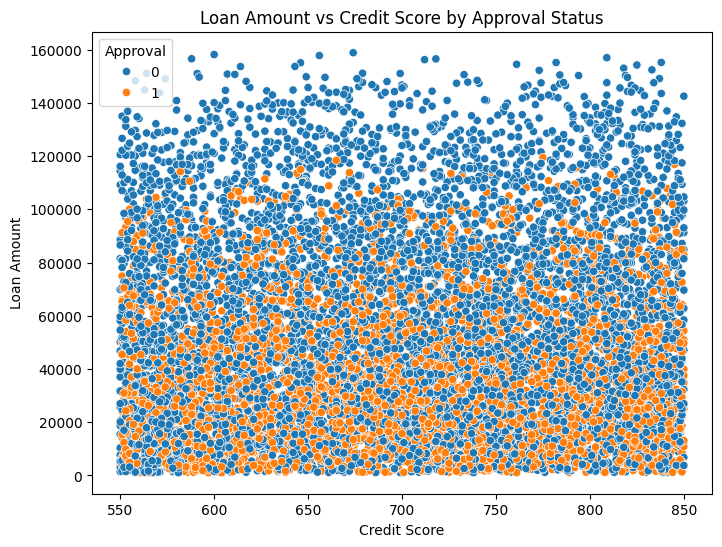

In [5]:
# lets examine the loan request amounts of well qualified applicants

# filter to only look at well qualified applicants
data_filtered = data[(data['DTI_Ratio'] >= 0) & (data['DTI_Ratio'] <= 50)]
data_filtered = data_filtered[data_filtered['Credit_Score'] >= 550]

# reformat the approval to be a string of 0 or 1 to be accepted by seaborn
data_filtered['Approval'] = data_filtered['Approval'].astype(str)

plt.figure(figsize=(8, 6))
sb.scatterplot(data=data_filtered, x="Credit_Score", y="Loan_Amount", hue="Approval")
plt.title("Loan Amount vs Credit Score by Approval Status")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

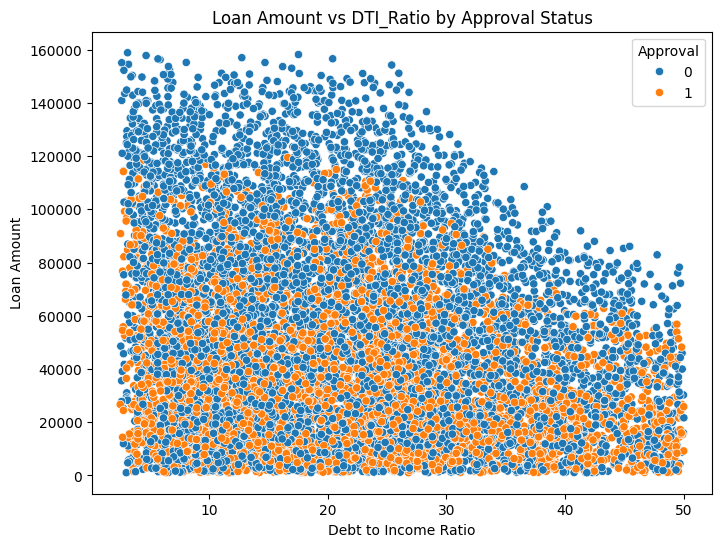

In [6]:
# repeat same logic

plt.figure(figsize=(8, 6))
sb.scatterplot(data=data_filtered, x="DTI_Ratio", y="Loan_Amount", hue="Approval")
plt.title("Loan Amount vs DTI_Ratio by Approval Status")
plt.xlabel("Debt to Income Ratio")
plt.ylabel("Loan Amount")
plt.show()

looks like any loan request over $120,000 is being rejected!!

In [7]:
count_high_DTI = data[(data['DTI_Ratio'] > 50) & (data['Approval'] == 1)].count
count_low_CS = data[(data['Credit_Score'] < 550) & (data['Approval'] == 1)].count
count_both = data_check_unqualified = data[(data['DTI_Ratio'] > 50) & (data['Credit_Score'] < 550) & (data['Approval'] == 1)].count

print(count_both, count_high_DTI, count_low_CS)

<bound method DataFrame.count of Empty DataFrame
Columns: [Text, Income, Credit_Score, Loan_Amount, DTI_Ratio, Employment_Status, Approval]
Index: []> <bound method DataFrame.count of Empty DataFrame
Columns: [Text, Income, Credit_Score, Loan_Amount, DTI_Ratio, Employment_Status, Approval]
Index: []> <bound method DataFrame.count of Empty DataFrame
Columns: [Text, Income, Credit_Score, Loan_Amount, DTI_Ratio, Employment_Status, Approval]
Index: []>


Confirms that **ANY** unqualified applicants will be **REJECTED**

***Parameters moving forward***
- Applicant must have...
    - credit_score >= 550
    - DTI_ratio <= 50
    - loan_amount < 120,000

**Last step before creating our final model is to categorize the request memo**

In [8]:
# update main data record
data_new = data[(data['DTI_Ratio'] >= 0) & 
            (data['Credit_Score'] >= 550) & 
            (data['Employment_Status'] == 1) & 
            (data['Loan_Amount'] < 120000)]

In [9]:
# run OLS on new parameter data

x = data_new[['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Employment_Status']]
x = sm.add_constant(x)
y = data_new['Approval']


result = sm.OLS(y, x).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Approval   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1733.
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        09:38:04   Log-Likelihood:                -2043.4
No. Observations:                6312   AIC:                             4097.
Df Residuals:                    6307   BIC:                             4131.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Income             4.568e-06   1.22e-0

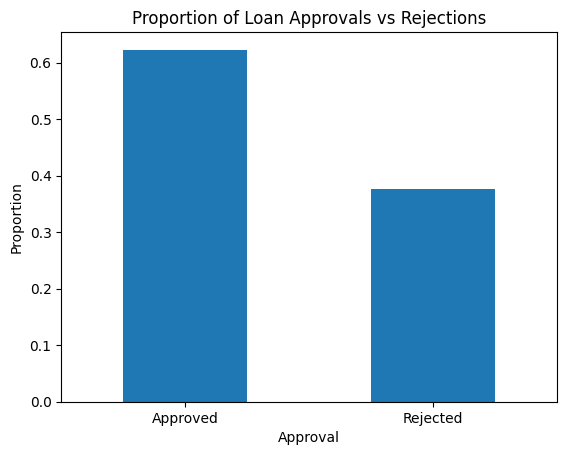

In [10]:
# might have to look at more categories
data_text = data_new.drop(
    labels=['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Employment_Status'],
    axis=1          # 0 for rows
)


# proportion graph of our uopdated set
proportions = data_text['Approval'].value_counts(normalize=True)  
proportions.plot(kind='bar')
plt.title('Proportion of Loan Approvals vs Rejections')
plt.xticks([0, 1], ['Approved', 'Rejected'], rotation=0)
plt.ylabel('Proportion')
plt.show()

In [11]:

# preprocessing helpers
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')  # For POS tagging (NLTK 3.8+)
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize


# convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  # remove leading/trailing whitespace
    text = re.compile(r'[%s]' % re.escape(string.punctuation)).sub(' ', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text)  # remove multiple whitespaces
    text = re.sub(r'\d',' ',text) # remove digits
    return text

# remove stopwords
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# Lemmatization
wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

# tokenize puts into vector
# pos_tag makes each vector tag a tuple of the word and part of speech
# tag[0] is the word, tag[1] is the part of speech
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags] # Map the position tag and lemmatize the word/token
    return " ".join(a)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukemcguinness/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukemcguinness/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lukemcguinness/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lukemcguinness/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/lukemcguinness/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [12]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

data_text['clean_text'] = data_text['Text'].apply(lambda x: finalpreprocess(x)) # apply finalprocess to each row
data_text.head(10)

,Text,Approval,clean_text
0,I need a loan to pay for an international vaca...,0,need loan pay international vacation family
4,I need a loan to start a small business.,1,need loan start small business
6,I need financial help to cover maternity and d...,1,need financial help cover maternity delivery e...
12,I want to start a small roadside food stall an...,0,want start small roadside food stall need fund...
15,I need financial support to pay for my son's f...,1,need financial support pay son football traini...
22,I need a loan to start a small business.,0,need loan start small business
23,I need money to purchase a food truck and star...,1,need money purchase food truck start business
28,I need funds to stock inventory for my new ret...,0,need fund stock inventory new retail store
30,I need a loan to pay for a down payment on my ...,1,need loan pay payment first home
33,I want to expand my small online clothing store.,0,want expand small online clothing store


In [14]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_text['clean_text'], data_text['Approval'], test_size=0.2, shuffle=True)

# vectorize the clean_text column
X_train_tok = [nltk.word_tokenize(i) for i in X_train]  
X_test_tok = [nltk.word_tokenize(i) for i in X_test]

In [15]:
# tokenize each entry
data_text['clean_text_tok'] = [nltk.word_tokenize(i) for i in data_text['clean_text']]

# include each word, even those that appear once
model = Word2Vec(data_text['clean_text_tok'], min_count=1)

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y=None):
        return self

    # convert into numerical feature vectors
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] or 
                    [np.zeros(self.dim)], axis=0)
            for words in X
        ])

modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# need handle class imbalance
lr_w2v = LogisticRegression(
    solver='liblinear',
    C=10,
    penalty='l2',
    class_weight='balanced'
)

# lr_w2v = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.39      0.46      0.43       492
           1       0.61      0.55      0.58       771

    accuracy                           0.51      1263
   macro avg       0.50      0.51      0.50      1263
weighted avg       0.53      0.51      0.52      1263

Confusion Matrix: [[227 265]
 [348 423]]
AUC: 0.4981375154218468


**Lets try a tf-idf instead becaus ethose results weren't goo great**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)


lr_tfidf = LogisticRegression(
    solver='liblinear',
    C=10,
    penalty='l2',
    class_weight='balanced'
)
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  


#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.39      0.40      0.39       492
           1       0.61      0.60      0.60       771

    accuracy                           0.52      1263
   macro avg       0.50      0.50      0.50      1263
weighted avg       0.52      0.52      0.52      1263

Confusion Matrix: [[195 297]
 [311 460]]
AUC: 0.4927965476152816


lets try to do a neural net with all of the meaningful categories instead because these aren't working too well